In [51]:
# %% [markdown]
# # Quick Draw Inference & Guessing API (JSON Input Only)
#
# This notebook demonstrates how to:
#
# - Preprocess raw JSON drawing data (with coordinate strokes from your Flutter board)
# - Convert the JSON data into the strokes format expected by the model
# - Load a pre-trained MobileNet model for Quick, Draw! classification (340 classes)
# - Run inference to output the top 3 predicted categories
# - Launch a Flask API endpoint (`/predict`) that accepts JSON drawing data and returns predictions
#
# **How to Run:**
#
# 1. **Install Dependencies** (if not already installed):
#    ```bash
#    !pip install rdp flask
#    ```
#
# 2. **Run Each Cell Sequentially** in Jupyter Notebook to test the inference pipeline.
#
# 3. **To Launch the API**: Export this notebook as a Python script (e.g., `app.py`) and run:
#    ```bash
#    python app.py
#    ```
#
# 4. **Test the API** with a POST request to `http://localhost:5000/predict` using your JSON stroke data.


In [52]:
# %% [code] cell="install_dependencies"
# Install required dependencies (uncomment if running for the first time)
!pip install rdp


In [53]:
# %% [code] cell="imports_config"
%matplotlib inline
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from scipy.interpolate import interp1d
from rdp import rdp  # Ensure you have installed with: pip install rdp
from flask import Flask, request, jsonify

start = dt.datetime.now()


In [54]:
# %% [markdown]
# ## Metrics Functions
#
# These functions are provided for evaluation and to define a custom metric (top-3 accuracy).


In [55]:
# %% [code] cell="metrics_functions"
def apk(actual, predicted, k=3):
    """
    Computes the average precision at k.
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """Mean average precision at k"""
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def top_3_accuracy(y_true, y_pred):
    """Keras metric for top-3 accuracy."""
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)


In [56]:
# %% [markdown]
# ## Model Setup and Loading
#
# We recreate the MobileNet architecture (with a 64×64 grayscale input and 340 output classes)
# and load the saved weights. Make sure the parameters (input size, number of classes, learning rate, etc.)
# match those used during training.
#
# The weight file is assumed to be in the `sample_data` folder.


In [57]:
# %% [markdown]
# ## Drawing Conversion Functions
#
# The function `draw_cv2` converts a list of strokes (each a pair of x and y coordinates)
# into a grayscale image. This is the format the model expects.


In [58]:
# %% [code] cell="model_loading"
# Model parameters
size = 64       # Image size used during training
NCATS = 340     # Number of classes

# Recreate the MobileNet model architecture exactly as during training.
model = MobileNet(input_shape=(size, size, 1), alpha=1.0, weights=None, classes=NCATS)
model.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=['categorical_crossentropy', 'categorical_accuracy', top_3_accuracy]
)

# Load the saved weights (update the path if necessary)
model.load_weights("./model.h5")
print("Model loaded successfully for inference!")
model.summary()


Model loaded successfully for inference!


Model: "mobilenet_1.00_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 32, 32, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 32, 32, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 16, 16, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 16, 16, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 16, 16, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 16, 16, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,576,788 (13.64 MB)

 Trainable params: 3,554,900 (13.56 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [59]:
# %% [markdown]
# ## Drawing Conversion Function
#
# `draw_cv2` converts a list of strokes (each stroke is a pair of lists: [x_coords, y_coords])
# into a grayscale image. This is the format the model expects.


In [60]:
# %% [code] cell="draw_cv2_function"
BASE_SIZE = 256  # Canvas size used during drawing

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    """
    Convert a list of strokes (each stroke is a pair of lists: [x_coords, y_coords])
    into a grayscale image.
    """
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            # Optionally, fade strokes over time
            color = 255 - min(t, 10) * 13 if time_color else 255
            pt1 = (int(stroke[0][i]), int(stroke[1][i]))
            pt2 = (int(stroke[0][i + 1]), int(stroke[1][i + 1]))
            cv2.line(img, pt1, pt2, color, lw)
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
    return img


In [61]:
# %% [markdown]
# ## Preprocessing Functions for JSON Stroke Data
#
# These functions take raw JSON drawing data (from your Flutter board) and:
#
# - Extract the strokes  
# - Align them to the top-left  
# - Uniformly scale to a 256×256 region  
# - Resample the strokes with 1-pixel spacing  
# - Simplify the strokes using the Ramer-Douglas-Peucker algorithm  
#
# Two helper functions (`render_image` and `render_image_json`) are provided for visualization.


In [62]:
# %% [code] cell="preprocessing_functions"
def extract_strokes(data):
    """Extract strokes from JSON data."""
    strokes = []
    for stroke in data:
        x_coords, y_coords = [], []
        for step in stroke["path"]["steps"]:
            if step["type"] in ["moveTo", "lineTo"]:
                x_coords.append(step["x"])
                y_coords.append(step["y"])
        strokes.append([x_coords, y_coords])
    return strokes

def align_to_top_left(strokes):
    """Align the drawing to the top-left corner."""
    all_x = np.concatenate([np.array(stroke[0]) for stroke in strokes])
    all_y = np.concatenate([np.array(stroke[1]) for stroke in strokes])
    min_x, min_y = np.min(all_x), np.min(all_y)
    aligned = []
    for stroke in strokes:
        aligned_x = np.array(stroke[0]) - min_x
        aligned_y = np.array(stroke[1]) - min_y
        aligned.append([aligned_x.tolist(), aligned_y.tolist()])
    return aligned

def uniformly_scale(strokes):
    """Uniformly scale the drawing to fit within a 256x256 region."""
    all_x = np.concatenate([np.array(stroke[0]) for stroke in strokes])
    all_y = np.concatenate([np.array(stroke[1]) for stroke in strokes])
    max_x, max_y = np.max(all_x), np.max(all_y)
    scale = 255 / max(max_x, max_y) if max(max_x, max_y) > 0 else 1
    scaled = []
    for stroke in strokes:
        scaled_x = (np.array(stroke[0]) * scale).tolist()
        scaled_y = (np.array(stroke[1]) * scale).tolist()
        scaled.append([scaled_x, scaled_y])
    return scaled

def resample_stroke(stroke, spacing=1):
    """Resample a stroke with 1-pixel spacing."""
    x = np.array(stroke[0])
    y = np.array(stroke[1])
    distances = np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2)
    cumulative = np.cumsum(distances)
    total = cumulative[-1]
    if total == 0:
        return stroke  # stroke with a single point
    num_points = int(total / spacing) + 1
    new_distances = np.linspace(0, total, num_points)
    fx = interp1d(cumulative, x, kind='linear')
    fy = interp1d(cumulative, y, kind='linear')
    resampled_x = fx(new_distances).tolist()
    resampled_y = fy(new_distances).tolist()
    return [resampled_x, resampled_y]

def resample_strokes(strokes, spacing=1):
    """Resample all strokes with 1-pixel spacing."""
    return [resample_stroke(stroke, spacing) for stroke in strokes]

def simplify_strokes(strokes, epsilon=2.0):
    """Simplify strokes using the Ramer-Douglas-Peucker algorithm."""
    simplified = []
    for stroke in strokes:
        x = np.array(stroke[0])
        y = np.array(stroke[1])
        points = np.column_stack((x, y))
        simplified_points = rdp(points, epsilon=epsilon)
        simplified_x, simplified_y = simplified_points[:, 0].tolist(), simplified_points[:, 1].tolist()
        simplified.append([simplified_x, simplified_y])
    return simplified

def process_drawing(drawing):
    """
    Given raw JSON drawing data (a list of stroke dictionaries),
    extract and process the strokes:
      1. Extract strokes
      2. Align to top-left
      3. Uniformly scale to a 256x256 region
      4. Resample strokes with 1-pixel spacing
      5. Simplify strokes
    Returns the processed strokes.
    """
    strokes = extract_strokes(drawing)
    strokes = align_to_top_left(strokes)
    strokes = uniformly_scale(strokes)
    strokes = resample_strokes(strokes)
    strokes = simplify_strokes(strokes, epsilon=2.0)
    return strokes

def render_image(image):
    """Display an image using matplotlib."""
    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()

def render_image_json(drawing):
    """Plot strokes from JSON drawing data."""
    strokes = extract_strokes(drawing)
    for stroke in strokes:
        x, y = stroke
        plt.plot(x, y, marker='o')
    plt.gca().invert_yaxis()
    plt.show()


In [63]:
# %% [markdown]
# ## Prediction Function
#
# The function `predict_drawing` takes raw strokes (in the same format as training),
# converts them into an image, preprocesses it, and returns the top 3 predicted categories
# with their probabilities.
#
# The helper function `list_all_categories` returns a dummy list of category names.
# Replace it with your actual label mapping if available.


In [64]:
# %% [code] cell="category_mapping"
quickdraw_labels = {
    0: "aircraft carrier",
    1: "airplane",
    2: "alarm clock",
    3: "ambulance",
    4: "angel",
    5: "animal migration",
    6: "ant",
    7: "anvil",
    8: "apple",
    9: "arm",
    10: "asparagus",
    11: "axe",
    12: "backpack",
    13: "banana",
    14: "bandage",
    15: "barn",
    16: "baseball bat",
    17: "baseball",
    18: "basket",
    19: "basketball",
    20: "bat",
    21: "bathtub",
    22: "beach",
    23: "bear",
    24: "beard",
    25: "bed",
    26: "bee",
    27: "belt",
    28: "bench",
    29: "bicycle",
    30: "binoculars",
    31: "bird",
    32: "birthday cake",
    33: "blackberry",
    34: "blueberry",
    35: "book",
    36: "boomerang",
    37: "bottlecap",
    38: "bowtie",
    39: "bracelet",
    40: "brain",
    41: "bread",
    42: "bridge",
    43: "broccoli",
    44: "broom",
    45: "bucket",
    46: "bulldozer",
    47: "bus",
    48: "bush",
    49: "butterfly",
    50: "cactus",
    51: "cake",
    52: "calculator",
    53: "calendar",
    54: "camel",
    55: "camera",
    56: "camouflage",
    57: "campfire",
    58: "candle",
    59: "cannon",
    60: "canoe",
    61: "car",
    62: "carrot",
    63: "castle",
    64: "cat",
    65: "ceiling fan",
    66: "cell phone",
    67: "cello",
    68: "chair",
    69: "chandelier",
    70: "church",
    71: "circle",
    72: "clarinet",
    73: "clock",
    74: "cloud",
    75: "coffee cup",
    76: "compass",
    77: "computer",
    78: "cookie",
    79: "cooler",
    80: "couch",
    81: "cow",
    82: "crab",
    83: "crayon",
    84: "crocodile",
    85: "crown",
    86: "cruise ship",
    87: "cup",
    88: "diamond",
    89: "dishwasher",
    90: "diving board",
    91: "dog",
    92: "dolphin",
    93: "donut",
    94: "door",
    95: "dragon",
    96: "dresser",
    97: "drill",
    98: "drums",
    99: "duck",
    100: "dumbbell",
    101: "ear",
    102: "elbow",
    103: "elephant",
    104: "envelope",
    105: "eraser",
    106: "eye",
    107: "eyeglasses",
    108: "face",
    109: "fan",
    110: "feather",
    111: "fence",
    112: "finger",
    113: "fire hydrant",
    114: "fireplace",
    115: "firetruck",
    116: "fish",
    117: "flamingo",
    118: "flashlight",
    119: "flip flops",
    120: "floor lamp",
    121: "flower",
    122: "flying saucer",
    123: "foot",
    124: "fork",
    125: "frog",
    126: "frying pan",
    127: "garden hose",
    128: "garden",
    129: "giraffe",
    130: "goatee",
    131: "golf club",
    132: "grapes",
    133: "grass",
    134: "guitar",
    135: "hamburger",
    136: "hammer",
    137: "hand",
    138: "harp",
    139: "hat",
    140: "headphones",
    141: "hedgehog",
    142: "helicopter",
    143: "helmet",
    144: "hexagon",
    145: "hockey puck",
    146: "hockey stick",
    147: "horse",
    148: "hospital",
    149: "hot air balloon",
    150: "hot dog",
    151: "hot tub",
    152: "hourglass",
    153: "house plant",
    154: "house",
    155: "hurricane",
    156: "ice cream",
    157: "jacket",
    158: "jail",
    159: "kangaroo",
    160: "key",
    161: "keyboard",
    162: "knee",
    163: "knife",
    164: "ladder",
    165: "lantern",
    166: "laptop",
    167: "leaf",
    168: "leg",
    169: "light bulb",
    170: "lighter",
    171: "lighthouse",
    172: "lightning",
    173: "line",
    174: "lion",
    175: "lipstick",
    176: "lobster",
    177: "lollipop",
    178: "mailbox",
    179: "map",
    180: "marker",
    181: "matches",
    182: "megaphone",
    183: "mermaid",
    184: "microphone",
    185: "microwave",
    186: "monkey",
    187: "moon",
    188: "mosquito",
    189: "motorbike",
    190: "mountain",
    191: "mouse",
    192: "moustache",
    193: "mouth",
    194: "mug",
    195: "mushroom",
    196: "nail",
    197: "necklace",
    198: "nose",
    199: "ocean",
    200: "octagon",
    201: "octopus",
    202: "onion",
    203: "oven",
    204: "owl",
    205: "paint can",
    206: "paintbrush",
    207: "palm tree",
    208: "panda",
    209: "pants",
    210: "paper clip",
    211: "parachute",
    212: "parrot",
    213: "passport",
    214: "peanut",
    215: "pear",
    216: "peas",
    217: "pencil",
    218: "penguin",
    219: "piano",
    220: "pickup truck",
    221: "picture frame",
    222: "pig",
    223: "pillow",
    224: "pineapple",
    225: "pizza",
    226: "pliers",
    227: "police car",
    228: "pond",
    229: "pool",
    230: "popsicle",
    231: "postcard",
    232: "potato",
    233: "power outlet",
    234: "purse",
    235: "rabbit",
    236: "raccoon",
    237: "radio",
    238: "rain",
    239: "rainbow",
    240: "rake",
    241: "remote control",
    242: "rhinoceros",
    243: "rifle",
    244: "river",
    245: "roller coaster",
    246: "rollerskates",
    247: "sailboat",
    248: "sandwich",
    249: "saw",
    250: "saxophone",
    251: "school bus",
    252: "scissors",
    253: "scorpion",
    254: "screwdriver",
    255: "sea turtle",
    256: "see saw",
    257: "shark",
    258: "sheep",
    259: "shoe",
    260: "shorts",
    261: "shovel",
    262: "sink",
    263: "skateboard",
    264: "skull",
    265: "skyscraper",
    266: "sleeping bag",
    267: "smiley face",
    268: "snail",
    269: "snake",
    270: "snorkel",
    271: "snowflake",
    272: "snowman",
    273: "soccer ball",
    274: "sock",
    275: "speedboat",
    276: "spider",
    277: "spoon",
    278: "spreadsheet",
    279: "square",
    280: "squiggle",
    281: "squirrel",
    282: "stairs",
    283: "star",
    284: "steak",
    285: "stereo",
    286: "stethoscope",
    287: "stitches",
    288: "stop sign",
    289: "stove",
    290: "strawberry",
    291: "streetlight",
    292: "string bean",
    293: "submarine",
    294: "suitcase",
    295: "sun",
    296: "swan",
    297: "sweater",
    298: "swing set",
    299: "sword",
    300: "syringe",
    301: "t-shirt",
    302: "table",
    303: "teapot",
    304: "teddy-bear",
    305: "telephone",
    306: "television",
    307: "tennis racquet",
    308: "tent",
    309: "The Eiffel Tower",
    310: "The Great Wall of China",
    311: "The Mona Lisa",
    312: "tiger",
    313: "toaster",
    314: "toe",
    315: "toilet",
    316: "tooth",
    317: "toothbrush",
    318: "toothpaste",
    319: "tornado",
    320: "tractor",
    321: "traffic light",
    322: "train",
    323: "tree",
    324: "triangle",
    325: "trombone",
    326: "truck",
    327: "trumpet",
    328: "umbrella",
    329: "underwear",
    330: "van",
    331: "vase",
    332: "violin",
    333: "washing machine",
    334: "watermelon",
    335: "waterslide",
    336: "whale",
    337: "wheel",
    338: "windmill",
    339: "wine bottle"
}


In [65]:
# %% [code] cell="prediction_function"
def list_all_categories():
    return [quickdraw_labels[i] for i in range(NCATS)]


def predict_drawing(raw_strokes):
    """
    Given raw drawing strokes, convert them to an image, preprocess for MobileNet,
    run inference, and return the top 3 predicted categories with probabilities.
    """
    img = draw_cv2(raw_strokes, size=size, lw=6, time_color=True)
    img = img.astype(np.float32)
    x = np.expand_dims(img, axis=0)   # Shape: (1, size, size)
    x = np.expand_dims(x, axis=-1)      # Shape: (1, size, size, 1)
    x = preprocess_input(x)
    predictions = model.predict(x)
    top3_idx = np.argsort(predictions[0])[-3:][::-1]
    top3_probs = predictions[0][top3_idx]
    cats = list_all_categories()
    top3_labels = [cats[idx] for idx in top3_idx]
    return list(zip(top3_labels, top3_probs))


In [66]:
# %% [markdown]
# ## Example Inference on JSON Drawing Data
#
# This cell demonstrates:
#
# - Loading a sample JSON drawing file (update the file path as needed)
# - Visualizing the original drawing
# - Processing the drawing to obtain simplified strokes
# - Converting the strokes to an image and running inference


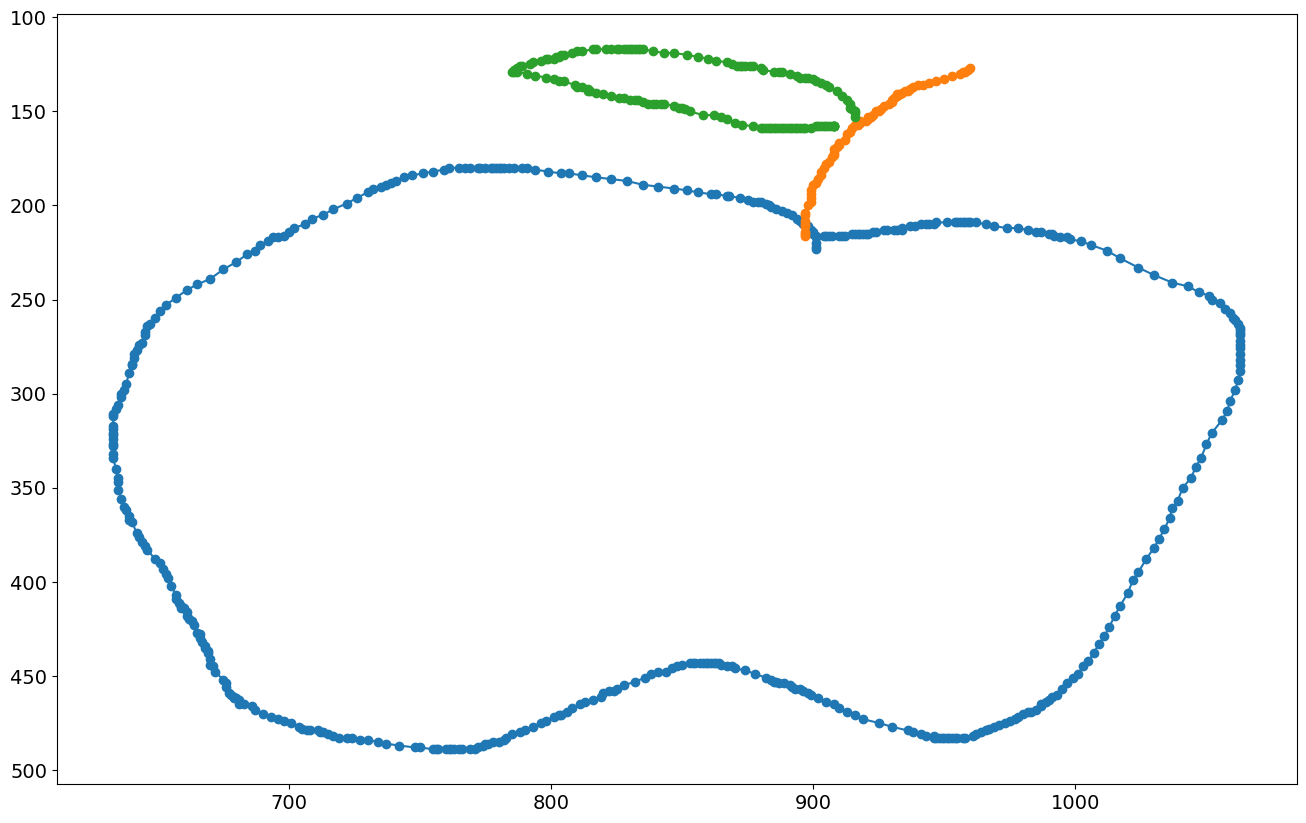

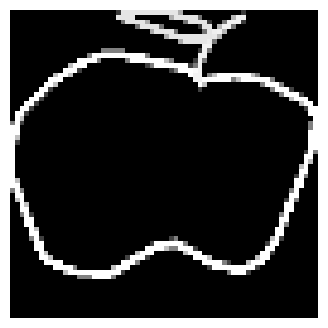

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top 3 Predictions (from JSON drawing):
apple: 0.9997
passport: 0.0001
pliers: 0.0001


In [67]:
# %% [code] cell="example_json_inference"
# Load sample JSON drawing data (update the path if needed)
import json
with open('./drawing.json', 'r') as file:
    json_data = json.load(file)

# Visualize the original drawing from JSON
render_image_json(json_data)

# Process the drawing to obtain simplified strokes
simplified_strokes = process_drawing(json_data)

# Create an image from the simplified strokes (model input)
img_generated = draw_cv2(simplified_strokes, size=size, lw=6, time_color=True)
render_image(img_generated)

# Preprocess the generated image for inference
img_generated = img_generated.astype(np.float32)
x_img = np.expand_dims(img_generated, axis=0)
x_img = np.expand_dims(x_img, axis=-1)
x_img = preprocess_input(x_img)

# Run inference on the processed drawing
predictions = model.predict(x_img)
top3_idx = np.argsort(predictions[0])[-3:][::-1]
top3_probs = predictions[0][top3_idx]
categories = list_all_categories()
top3_labels = [quickdraw_labels[idx + 1] for idx in top3_idx]

print("Top 3 Predictions (from JSON drawing):")
for label, prob in zip(top3_labels, top3_probs):
    print(f"{label}: {prob:.4f}")


In [68]:
# %% [markdown]
# ## Quick, Draw! Category Mapping
#
# This dictionary maps category IDs (0 to 339) to their corresponding names.
# Update this mapping if you have a different label set.


In [69]:
# %% [markdown]
# ## Guessing API using Flask
#
# The following cell creates a simple Flask API with a `/predict` endpoint.
# The endpoint expects a POST request with JSON drawing data (containing coordinate strokes),
# processes the drawing, and returns the top 3 predicted categories and their probabilities.
#
# **How to Run the API:**
#
# 1. Export this notebook as a Python script (e.g., `app.py`).
# 2. In your terminal, run:
#    ```bash
#    python app.py
#    ```
# 3. The API will start on port 5000.
# 4. Send a POST request (using curl or Postman) to:
#    `http://localhost:5000/predict`
#    with a JSON body containing the drawing strokes.


In [ ]:
# %% [code] cell="flask_api"
from flask import Flask, request, jsonify
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    """
    Endpoint to receive JSON drawing data, process it, and return the top 3 predictions.
    
    Expected JSON format:
    [
       {
         "path": {
             "steps": [
                 {"type": "moveTo", "x": <value>, "y": <value>},
                 {"type": "lineTo", "x": <value>, "y": <value>},
                 ...
             ]
         }
       },
       ...
    ]
    """
    data = request.get_json()
    if not data:
        return jsonify({"error": "No JSON data provided"}), 400
    try:
        # Process the drawing from JSON data
        processed_strokes = process_drawing(data)
        # Convert strokes to an image
        img = draw_cv2(processed_strokes, size=size, lw=6, time_color=True)
        img = img.astype(np.float32)
        x_input = np.expand_dims(img, axis=0)
        x_input = np.expand_dims(x_input, axis=-1)
        x_input = preprocess_input(x_input)
        # Run prediction
        preds = model.predict(x_input)
        top3_idx = np.argsort(preds[0])[-3:][::-1]
        top3_probs = preds[0][top3_idx]
        cats = list_all_categories()
        results = [{"category": cats[idx + 1] if idx + 1 < len(cats) else cats[idx], 
            "probability": float(top3_probs[i])} 
           for i, idx in enumerate(top3_idx)]
        return jsonify({"predictions": results})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001, debug=True, use_reloader=False)



 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://10.80.3.163:5001
Press CTRL+C to quit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


127.0.0.1 - - [15/Feb/2025 07:49:54] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


127.0.0.1 - - [15/Feb/2025 07:55:07] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 07:55:20] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


127.0.0.1 - - [15/Feb/2025 07:55:21] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


127.0.0.1 - - [15/Feb/2025 07:56:05] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


127.0.0.1 - - [15/Feb/2025 07:58:15] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   


127.0.0.1 - - [15/Feb/2025 08:04:25] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


127.0.0.1 - - [15/Feb/2025 08:12:27] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


127.0.0.1 - - [15/Feb/2025 08:15:05] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 08:15:09] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:10] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:11] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:11] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:13] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:13] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:14] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:17] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:19] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:20] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:21] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:23] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:24] "POST /predict HTTP/1.1" 500 -
127.0.0.1 - - [15/Feb/2025 08:15:24] "POST /pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


127.0.0.1 - - [15/Feb/2025 08:15:34] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


127.0.0.1 - - [15/Feb/2025 08:15:35] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


127.0.0.1 - - [15/Feb/2025 08:15:37] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 08:15:38] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 08:15:39] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


127.0.0.1 - - [15/Feb/2025 08:15:40] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


127.0.0.1 - - [15/Feb/2025 08:15:40] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 08:15:41] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 08:15:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


127.0.0.1 - - [15/Feb/2025 08:15:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 08:15:44] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


127.0.0.1 - - [15/Feb/2025 08:15:45] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


127.0.0.1 - - [15/Feb/2025 08:15:49] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


127.0.0.1 - - [15/Feb/2025 08:15:57] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


127.0.0.1 - - [15/Feb/2025 08:15:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


127.0.0.1 - - [15/Feb/2025 08:15:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


127.0.0.1 - - [15/Feb/2025 08:15:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


127.0.0.1 - - [15/Feb/2025 08:15:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 08:16:38] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


127.0.0.1 - - [15/Feb/2025 08:16:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


127.0.0.1 - - [15/Feb/2025 08:33:26] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [15/Feb/2025 08:33:26] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 08:33:26] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [15/Feb/2025 08:33:33] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 08:33:36] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


127.0.0.1 - - [15/Feb/2025 08:33:38] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


127.0.0.1 - - [15/Feb/2025 08:33:41] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


127.0.0.1 - - [15/Feb/2025 08:33:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [15/Feb/2025 08:33:44] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 08:33:46] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


127.0.0.1 - - [15/Feb/2025 08:33:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


127.0.0.1 - - [15/Feb/2025 08:33:50] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


127.0.0.1 - - [15/Feb/2025 08:33:51] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


127.0.0.1 - - [15/Feb/2025 08:33:54] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 08:35:39] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [15/Feb/2025 08:35:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


127.0.0.1 - - [15/Feb/2025 08:35:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


127.0.0.1 - - [15/Feb/2025 08:35:47] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 08:35:50] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


127.0.0.1 - - [15/Feb/2025 08:35:51] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


127.0.0.1 - - [15/Feb/2025 08:35:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


127.0.0.1 - - [15/Feb/2025 08:36:00] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


127.0.0.1 - - [15/Feb/2025 08:36:02] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


127.0.0.1 - - [15/Feb/2025 08:36:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


127.0.0.1 - - [15/Feb/2025 08:36:07] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


127.0.0.1 - - [15/Feb/2025 08:36:13] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 08:36:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


127.0.0.1 - - [15/Feb/2025 08:36:57] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


127.0.0.1 - - [15/Feb/2025 07:54:46] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


127.0.0.1 - - [15/Feb/2025 07:54:49] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 07:54:51] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


127.0.0.1 - - [15/Feb/2025 07:54:52] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


127.0.0.1 - - [15/Feb/2025 07:54:53] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 07:54:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 07:55:23] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


127.0.0.1 - - [15/Feb/2025 07:55:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


127.0.0.1 - - [15/Feb/2025 07:55:32] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 07:58:16] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 07:58:19] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


127.0.0.1 - - [15/Feb/2025 08:04:16] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


127.0.0.1 - - [15/Feb/2025 08:04:19] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


127.0.0.1 - - [15/Feb/2025 08:12:25] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


127.0.0.1 - - [15/Feb/2025 08:12:29] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


127.0.0.1 - - [15/Feb/2025 08:15:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


127.0.0.1 - - [15/Feb/2025 08:15:10] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:18] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


127.0.0.1 - - [15/Feb/2025 08:15:21] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


127.0.0.1 - - [15/Feb/2025 08:15:22] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


127.0.0.1 - - [15/Feb/2025 08:15:34] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


127.0.0.1 - - [15/Feb/2025 08:15:39] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


127.0.0.1 - - [15/Feb/2025 08:15:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:45] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


127.0.0.1 - - [15/Feb/2025 08:15:51] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


127.0.0.1 - - [15/Feb/2025 08:15:54] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


127.0.0.1 - - [15/Feb/2025 08:15:54] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


127.0.0.1 - - [15/Feb/2025 08:15:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:15:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 08:16:39] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:16:46] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


127.0.0.1 - - [15/Feb/2025 08:16:49] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 08:33:23] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


127.0.0.1 - - [15/Feb/2025 08:33:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:33:31] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [15/Feb/2025 08:33:37] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


127.0.0.1 - - [15/Feb/2025 08:35:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


127.0.0.1 - - [15/Feb/2025 08:35:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


127.0.0.1 - - [15/Feb/2025 08:36:02] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


127.0.0.1 - - [15/Feb/2025 08:36:05] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


127.0.0.1 - - [15/Feb/2025 08:36:09] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


127.0.0.1 - - [15/Feb/2025 09:30:33] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


127.0.0.1 - - [15/Feb/2025 09:30:34] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


127.0.0.1 - - [15/Feb/2025 09:30:35] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


127.0.0.1 - - [15/Feb/2025 09:30:37] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:30:38] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:30:40] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


127.0.0.1 - - [15/Feb/2025 09:30:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


127.0.0.1 - - [15/Feb/2025 09:30:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


127.0.0.1 - - [15/Feb/2025 09:30:45] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


127.0.0.1 - - [15/Feb/2025 09:30:46] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 09:30:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


127.0.0.1 - - [15/Feb/2025 09:30:49] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


127.0.0.1 - - [15/Feb/2025 09:30:50] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


127.0.0.1 - - [15/Feb/2025 09:30:52] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


127.0.0.1 - - [15/Feb/2025 09:30:53] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


127.0.0.1 - - [15/Feb/2025 09:30:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


127.0.0.1 - - [15/Feb/2025 09:30:57] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


127.0.0.1 - - [15/Feb/2025 09:31:00] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


127.0.0.1 - - [15/Feb/2025 09:31:01] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:31:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


127.0.0.1 - - [15/Feb/2025 09:33:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


127.0.0.1 - - [15/Feb/2025 09:36:19] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:36:21] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


127.0.0.1 - - [15/Feb/2025 09:36:23] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 09:36:26] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


127.0.0.1 - - [15/Feb/2025 09:36:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


127.0.0.1 - - [15/Feb/2025 09:36:31] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:36:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [15/Feb/2025 09:36:45] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


127.0.0.1 - - [15/Feb/2025 09:36:53] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:37:01] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:37:04] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:37:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


127.0.0.1 - - [15/Feb/2025 09:37:27] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [15/Feb/2025 09:38:46] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


127.0.0.1 - - [15/Feb/2025 09:38:47] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


127.0.0.1 - - [15/Feb/2025 09:38:50] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


127.0.0.1 - - [15/Feb/2025 09:38:52] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


127.0.0.1 - - [15/Feb/2025 09:38:57] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


127.0.0.1 - - [15/Feb/2025 09:39:02] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


127.0.0.1 - - [15/Feb/2025 09:39:29] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


127.0.0.1 - - [15/Feb/2025 09:39:34] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


127.0.0.1 - - [15/Feb/2025 09:39:36] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


127.0.0.1 - - [15/Feb/2025 09:39:38] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


127.0.0.1 - - [15/Feb/2025 09:39:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


127.0.0.1 - - [15/Feb/2025 09:39:45] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


127.0.0.1 - - [15/Feb/2025 09:39:49] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 09:39:51] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [15/Feb/2025 09:42:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


127.0.0.1 - - [15/Feb/2025 09:42:57] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


127.0.0.1 - - [15/Feb/2025 09:43:01] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


127.0.0.1 - - [15/Feb/2025 09:43:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


127.0.0.1 - - [15/Feb/2025 09:43:04] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


127.0.0.1 - - [15/Feb/2025 09:43:05] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


127.0.0.1 - - [15/Feb/2025 09:43:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


127.0.0.1 - - [15/Feb/2025 09:43:08] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:43:09] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


127.0.0.1 - - [15/Feb/2025 09:43:15] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


127.0.0.1 - - [15/Feb/2025 09:43:20] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


127.0.0.1 - - [15/Feb/2025 09:43:22] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


127.0.0.1 - - [15/Feb/2025 09:43:23] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [15/Feb/2025 09:43:26] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


127.0.0.1 - - [15/Feb/2025 09:43:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


127.0.0.1 - - [15/Feb/2025 09:55:18] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:55:20] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


127.0.0.1 - - [15/Feb/2025 09:56:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


127.0.0.1 - - [15/Feb/2025 09:56:46] "POST /predict HTTP/1.1" 200 -


In [ ]:
# %% [markdown]
# ## Final Notes
#
# - **Running the Notebook:**  
#   Run each cell sequentially in Jupyter Notebook to test the full JSON-based inference pipeline.
#
# - **Running the API:**  
#   Export the notebook as a Python script (e.g., `app.py`) and run `python app.py` from the terminal.
#   Then send a POST request to `http://localhost:5000/predict` with your JSON stroke data.
#
# - **JSON Data Format:**  
#   The expected JSON format is a list of stroke dictionaries, for example:
#
#   ```json
#   [
#     {
#       "path": {
#         "steps": [
#           {"type": "moveTo", "x": 10, "y": 10},
#           {"type": "lineTo", "x": 20, "y": 15},
#           ...
#         ]
#       }
#     },
#     ...
#   ]
#   ```
#
# Enjoy and feel free to adjust any part of the pipeline for your specific needs!
